In [ ]:
!pip install torchvision

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils  # Corrected import
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import pathlib
from torch import optim


In [21]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)


In [41]:
#splitting data {80% training, 20% validation}
import os
import shutil
from sklearn.model_selection import train_test_split


brain_tumor =r'D:\data\tumor' #brain_dir
no_tumor =r'D:\data\notumor' #no_brain_dir
#print(brain_tumor)
# Paths for the new train/validation split
train_dir ='D:/data/train'
val_dir ='D:/data/val'
print("Brain files:", os.listdir(brain_tumor))
print("No Brain files:", os.listdir(no_tumor))


# train/validation directories
os.makedirs(os.path.join(train_dir, 'tumor'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'notumor'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'tumor'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'notumor'), exist_ok=True)


# 20/100 * brain.size ... 20/100 * no brain.size
def split_and_move_files(src_dir, train_dst, val_dst, test_size=0.2):
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    print("1 get all files done")

    train_files, val_files = train_test_split(files, test_size=test_size, random_state=42)
    print("2 split done")

    for file in train_files:
        shutil.move(os.path.join(src_dir, file), os.path.join(train_dst, file))
    print("3 shutil done")

    for file in val_files:
        shutil.move(os.path.join(src_dir, file), os.path.join(val_dst, file))
    print("4 move done")

split_and_move_files(brain_tumor, os.path.join(train_dir, 'tumor'), os.path.join(val_dir, 'tumor'))
print("done")
split_and_move_files(no_tumor, os.path.join(train_dir, 'notumor'), os.path.join(val_dir, 'notumor'))

print("Dataset split into training and validation sets.")
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

Brain files: ['Tr-piTr_0000.jpg', 'Tr-piTr_0001.jpg', 'Tr-piTr_0002.jpg', 'Tr-piTr_0003.jpg', 'Tr-piTr_0004.jpg', 'Tr-piTr_0005.jpg', 'Tr-piTr_0006.jpg', 'Tr-piTr_0007.jpg', 'Tr-piTr_0008.jpg', 'Tr-piTr_0009.jpg', 'Tr-pi_0010.jpg', 'Tr-pi_0011.jpg', 'Tr-pi_0012.jpg', 'Tr-pi_0013.jpg', 'Tr-pi_0014.jpg', 'Tr-pi_0015.jpg', 'Tr-pi_0016.jpg', 'Tr-pi_0017.jpg', 'Tr-pi_0018.jpg', 'Tr-pi_0019.jpg', 'Tr-pi_0020.jpg', 'Tr-pi_0021.jpg', 'Tr-pi_0022.jpg', 'Tr-pi_0023.jpg', 'Tr-pi_0024.jpg', 'Tr-pi_0025.jpg', 'Tr-pi_0026.jpg', 'Tr-pi_0027.jpg', 'Tr-pi_0028.jpg', 'Tr-pi_0029.jpg', 'Tr-pi_0030.jpg', 'Tr-pi_0031.jpg', 'Tr-pi_0032.jpg', 'Tr-pi_0033.jpg', 'Tr-pi_0034.jpg', 'Tr-pi_0035.jpg', 'Tr-pi_0036.jpg', 'Tr-pi_0037.jpg', 'Tr-pi_0038.jpg', 'Tr-pi_0039.jpg', 'Tr-pi_0040.jpg', 'Tr-pi_0041.jpg', 'Tr-pi_0042.jpg', 'Tr-pi_0043.jpg', 'Tr-pi_0044.jpg', 'Tr-pi_0045.jpg', 'Tr-pi_0046.jpg', 'Tr-pi_0047.jpg', 'Tr-pi_0048.jpg', 'Tr-pi_0049.jpg', 'Tr-pi_0050.jpg', 'Tr-pi_0051.jpg', 'Tr-pi_0052.jpg', 'Tr-pi_0053.

In [43]:
train_dataset.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [45]:
val_dataset.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


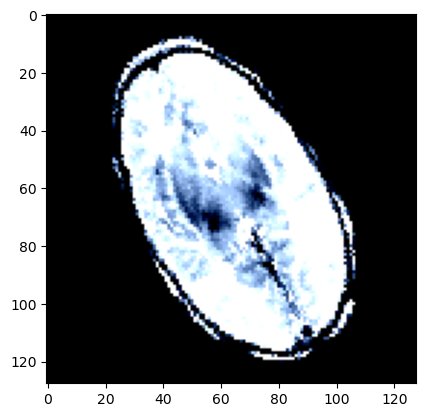

In [51]:
img,label=train_dataset[1000]
plt.imshow(img.permute(1,2,0))

In [57]:
batch_size=64
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

In [59]:
next(iter(val_loader))[0].shape

torch.Size([64, 3, 128, 128])

In [143]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        # 1 Conv2d
        self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        # 1 Max Pool2d
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # 2 Conv2d
        self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        # 2 Max Pool2d
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # 3 Conv2d
        self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        # 3 Max Pool2d
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        # 4 Conv2d
        self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)
        # 4 Max Pool2d
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        # Activation function
        self.leakyRelu = nn.LeakyReLU(negative_slope=0.01)

        # Fully connected layers (adjusted input size based on the output shape)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)  # Adjusted to match the flattened tensor size
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        # (1) First layer
        out = self.leakyRelu(self.cnv1(x))
        out = self.maxpool1(out)
        # (2) Second layer
        out = self.leakyRelu(self.cnv2(out))
        out = self.maxpool2(out)
        # (3) Third layer
        out = self.leakyRelu(self.cnv3(out))
        out = self.maxpool3(out)
        # (4) Fourth layer
        out = self.leakyRelu(self.cnv4(out))
        out = self.maxpool4(out)
    
        # Print shape of output after conv layers and pooling
        print("Shape before flattening:", out.shape)

        # Flatten the output
        out = out.view(out.size(0), -1)

        # Print shape after flattening
        print("Shape after flattening:", out.shape)

        # Fully connected layers
        out = self.leakyRelu(self.fc1(out))
        out = self.fc2(out)
        
        return out


In [133]:
CNNmodel().forward

<bound method CNNmodel.forward of CNNmodel(
  (cnv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leakyRelu): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)>

In [145]:
#train this nigga
epochs=10
model=CNNmodel()
error=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
schedular=ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5)

In [153]:
from torch.optim.lr_scheduler import StepLR

train_loss_list = []
val_loss_list = []
accuracy_list = []

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    model.train()  # Set model to training mode
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = error(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        print("loss in loop:", i, ":", loss.item())

    # Validation
    model.eval()  
    total = 0
    correct = 0
    with torch.no_grad():  
        for images, labels in val_loader:
            outputs = model(images)
            v_loss = error(outputs, labels)
            val_loss += v_loss.item()
            predicted = torch.max(outputs.data, 1)[1]
            total += len(labels)
            correct += (predicted == labels).sum().item()  # Convert tensor to scalar

    # Update the scheduler
    scheduler.step()  # Update the learning rate

    accuracy = 100 * correct / total

    train_loss_list.append(train_loss / len(train_loader))
    val_loss_list.append(val_loss / len(val_loader))
    accuracy_list.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, "
          f"Accuracy: {accuracy:.2f}%")


Shape before flattening: torch.Size([64, 128, 4, 4])
Shape after flattening: torch.Size([64, 2048])
loss in loop: 0 : 0.3882853388786316
Shape before flattening: torch.Size([64, 128, 4, 4])
Shape after flattening: torch.Size([64, 2048])
loss in loop: 1 : 0.4396643042564392
Shape before flattening: torch.Size([64, 128, 4, 4])
Shape after flattening: torch.Size([64, 2048])
loss in loop: 2 : 0.37035635113716125
Shape before flattening: torch.Size([64, 128, 4, 4])
Shape after flattening: torch.Size([64, 2048])
loss in loop: 3 : 0.4756281077861786
Shape before flattening: torch.Size([64, 128, 4, 4])
Shape after flattening: torch.Size([64, 2048])
loss in loop: 4 : 0.333968847990036
Shape before flattening: torch.Size([64, 128, 4, 4])
Shape after flattening: torch.Size([64, 2048])
loss in loop: 5 : 0.43712499737739563
Shape before flattening: torch.Size([64, 128, 4, 4])
Shape after flattening: torch.Size([64, 2048])
loss in loop: 6 : 0.35110026597976685
Shape before flattening: torch.Size([64

In [157]:
import os

# Check if the directory exists, if not create it
if not os.path.exists(r'D:\tmp'):
    os.makedirs(r'D:\tmp')

# Now save the model
torch.save(model.state_dict(), r'D:\tmp\cnn_model.pth')
print("Model saved to D:\\tmp\\cnn_model.pth")


Model saved to D:\tmp\cnn_model.pth
